In [1]:
import os
import cv2
import random
import seaborn as sns
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pandas as pd
%matplotlib inline

### Basic vizualisation of the images and the directory configuration

In [2]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdirectories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [3]:
def show_random_images_from_dataset(dir_path):
    """
    dir_path (string) = path to the directiory that contains .jpg or .png 
    
    Raises:
        FileNotFoundError: If no '.png' or '.jpg' images are found in the directory.
    
    """
    files = os.listdir(dir_path)
    
    image_files = [f for f in files if f.endswith('.png') or f.endswith('.jpg')]  # first f for list comprehension 
    
    if not image_files:
        raise FileNotFoundError("No '.png' or '.jpg' images found in the directory.")
    
    random_images = random.sample(image_files, min(3, len(image_files)))
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 15))   # Create subplots
    

    for i, img_name in enumerate(random_images):  #  enumerate returns a tuple 
        
        img_path = os.path.join(dir_path, img_name) # Construct the full path to the image
        
        img = cv2.imread(img_path)
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img_rgb) # Display the image in subplot
        
    
    plt.show()

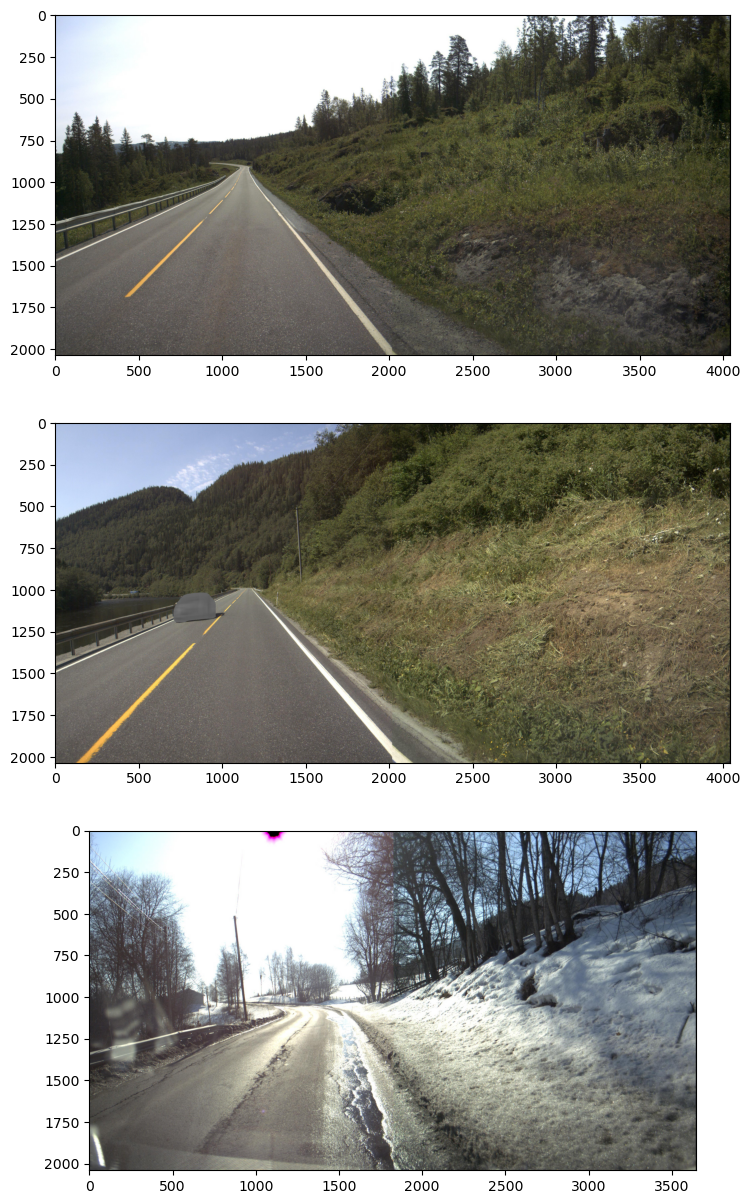

In [4]:
dataset_dir = r"D:\Work\Road Damage Detection\Datasets\RDD2022_all_countries\Norway\train\images"
try:
    show_random_images_from_dataset(dataset_dir)
except FileNotFoundError as e:
    print(e)

In [5]:
def find_image_path(xml_filename, image_dir):
    """
    Finds the corresponding image path for a given XML file name
    
    Args:
        xml_filename (str): Name of the XML file (without extension)
        image_dir (str): Directory containing the image files
        
    Returns:
        str: Absolute path to the corresponding image file (JPEG or PNG)
    """
    for file,_,dirs in os.walk(image_dir):
        if file.startswith(xml_filename) and (file.endswith('.jpg') or file.endswith('.png')):
            print("image file found")
            return os.path.join(image_dir, file)
        
    return None

In [6]:
def visualize_annotations(xml_path,base_dir):
    """
    
    WIP
    
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    folder = root.find('folder').text  # recovers the folder name from xml
    xml_filename = root.find('filename').text  # recovers filename from xml
    image_path = find_image_path(xml_filename, base_dir)
    
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return
    
    # Add bounding boxes with text of classes
    for record in root.findall('object'):
        category = record.find('name').text
        xmin = int(float(record.find('bndbox').find('xmin').text))
        ymin = int(float(record.find('bndbox').find('ymin').text))
        xmax = int(float(record.find('bndbox').find('xmax').text))
        ymax = int(float(record.find('bndbox').find('ymax').text))
        
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(image, category, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
    cv2.imshow(image)
    
    while True:
        key = cv2.waitKey(0) 
        
        if key == ord('q'):  # Close window if 'q' key is pressed
            cv2.destroyAllWindows()
            return
        

In [7]:
xml_file1 = r"D:\Work\Road Damage Detection\Datasets\CzInJapDataset\Czech\annotations\xmls\Czech_000070.xml"
base_dir = r"D:\Work\Road Damage Detection\Datasets\CzInJapDataset\Czech"
visualize_annotations(xml_file1,base_dir)

Error: Unable to load image at None


In [8]:
def read_annotations_from_xml(xml_file):
    """
    Read annotations from an XML file.
    
    Args:
        xml_file (str): Path to the XML file containing annotations.
    
    Returns:
        list: List of dictionaries representing annotations.
    """
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        image_filename = root.find('filename').text
        annotations = []

        # Check for presence of objects
        objects = root.findall("object")

        if len(objects) == 0:  # No bonding box objects found, saving just the filename
            annotations.append({'filename': image_filename, 'name': None, 'xmin': None, 'ymin': None, 'xmax': None, 'ymax': None})

        else:
            for obj in objects:  # Add all boject information to the annotation list
                name = obj.find('name').text  # Name being, the name of the class of road damage
                bbox = obj.find('bndbox')
                x_min = int(float(bbox.find('xmin').text))
                y_min = int(float(bbox.find('ymin').text))
                x_max = int(float(bbox.find('xmax').text))
                y_max = int(float(bbox.find('ymax').text))

            annotations.append({'filename': image_filename, 'name': name, 'xmin': x_min, 'ymin': y_min, 'xmax': x_max, 'ymax': y_max})

        return annotations
    
    except ValueError:
        print(f"Skipping XML file '{xml_file}' due to ValueError when converting coordinates to integers.")
        return []

In [10]:
inp = r"D:\Work\Road Damage Detection\Datasets\RDD2022_all_countries\China_MotorBike\train\annotations\China_MotorBike_000049.xml"
read_annotations_from_xml(inp)

[{'filename': 'China_MotorBike_000049.jpg',
  'name': 'D00',
  'xmin': 258,
  'ymin': 21,
  'xmax': 477,
  'ymax': 511}]

### Create dataframes of each damage directory in the dataset

#### Czech dataset first...

In [11]:
# Initialize an empty list to store dictionaries representing rows
data_rows = []
xml_dir_cz = r"D:\Work\Road Damage Detection\Datasets\CzInJapDataset\Czech\annotations\xmls"

# Iterate through XML files in the directory
for filename in os.listdir(xml_dir_cz):
    if filename.endswith('.xml'):
        xml_file = os.path.join(xml_dir_cz, filename)
        annotations = read_annotations_from_xml(xml_file)
        data_rows.extend(annotations)  #extends the data_rows list with an aditional directory list 

# Create DataFrame
df_cz = pd.DataFrame(data_rows)

In [12]:
# df_cz.to_csv("CzDataset.csv", index = False)

#### Combined Japan India and Czech dataset

In [13]:
data_rows = []
root_directory = r"D:\Work\Road Damage Detection\Datasets\CzInJapDataset"

# Iterate through XML files in the directory
for root, dirs, files in os.walk(root_directory):
    for file in files:
        if file.endswith('.xml'):
            xml_file = os.path.join(root, file)
            annotations = read_annotations_from_xml(xml_file)
            data_rows.extend(annotations)  # extends the data_rows list with an aditional directory list 

# Create DataFrame 
df_cz_in_jp = pd.DataFrame(data_rows)

In [14]:
# df_cz_in_jp.to_csv("CzInJapDataset.csv", index = False)

#### Indian

In [15]:
data_rows = []
xml_dir_in = r"D:\Work\Road Damage Detection\Datasets\CzInJapDataset\India\annotations"

# Iterate through XML files in the directory
for filename in os.listdir(xml_dir_in):
    if filename.endswith('.xml'):
        xml_file = os.path.join(xml_dir_in, filename)
        annotations = read_annotations_from_xml(xml_file)
        data_rows.extend(annotations)  #extends the data_rows list with an aditional directory list 

# Create DataFrame
df_in = pd.DataFrame(data_rows)

In [16]:
# df_in.to_csv("InDataset.csv", index = False)

#### Japan

In [17]:
data_rows = []
xml_dir_jp = r"D:\Work\Road Damage Detection\Datasets\CzInJapDataset\Japan\annotations"

# Iterate through XML files in the directory
for filename in os.listdir(xml_dir_jp):
    if filename.endswith('.xml'):
        xml_file = os.path.join(xml_dir_jp, filename)
        annotations = read_annotations_from_xml(xml_file)
        data_rows.extend(annotations)  #extends the data_rows list with an aditional directory list 

# Create DataFrame
df_jp = pd.DataFrame(data_rows)

In [18]:
# df_jp.to_csv("JpDataset.csv", index = False)

#### USA

In [20]:
data_rows = []
xml_dir_usa = r"D:\Work\Road Damage Detection\Datasets\RDD2022_all_countries\United_States\train\annotations"

# Iterate through XML files in the directory
for filename in os.listdir(xml_dir_usa):
    if filename.endswith('.xml'):
        xml_file = os.path.join(xml_dir_usa, filename)
        annotations = read_annotations_from_xml(xml_file)
        data_rows.extend(annotations)  #extends the data_rows list with an aditional directory list 

# Create DataFrame
df_usa = pd.DataFrame(data_rows)

In [ ]:
#df_usa.to_csv("UsaDataset.csv", index = False)

#### Combined Complete Datastet

In [21]:
data_rows = []
root_directory = r"D:\Work\Road Damage Detection\Datasets\RDD2022_all_countries"

# Iterate through XML files in the directory
for root, dirs, files in os.walk(root_directory):
    for file in files:
        if file.endswith('.xml'):
            xml_file = os.path.join(root, file)
            annotations = read_annotations_from_xml(xml_file)
            data_rows.extend(annotations)  # extends the data_rows list with an aditional directory list 

# Create DataFrame 
df_all_data = pd.DataFrame(data_rows)

In [22]:
#df_all_data.to_csv("csvs of datastets\AllData.csv\AllData.csv", index = False)

#### Norge

In [23]:
data_rows = []
root_directory = r"D:\Work\Road Damage Detection\Datasets\RDD2022_all_countries\Norway"

# Iterate through XML files in the directory
for root, dirs, files in os.walk(root_directory):
    for file in files:
        if file.endswith('.xml'):
            xml_file = os.path.join(root, file)
            annotations = read_annotations_from_xml(xml_file)
            data_rows.extend(annotations)  # extends the data_rows list with an aditional directory list 

# Create DataFrame 
df_norge = pd.DataFrame(data_rows)

In [ ]:
# df_norge.to_csv("Norge.csv", index = False)

In [24]:
df_all_data["roi_area"] = (df_all_data["xmax"] - df_all_data["xmin"]) * (df_all_data["ymax"] - df_all_data["ymin"])

In [25]:
df_all_data.groupby("name")["roi_area"].mean()

name
D00       31888.778338
D01       18281.390244
D0w0      19895.000000
D10       16289.941257
D11       19030.458333
D20       54612.478570
D40       11553.768670
D43       58549.724518
D44       21908.933951
D50        1647.634888
Repair    46380.366509
Name: roi_area, dtype: float64

### Vizualise datasets with countplots

![title](RoadDamageTypeDef.png)

<Axes: title={'center': 'Every Dataset Directory'}, xlabel='name', ylabel='count'>

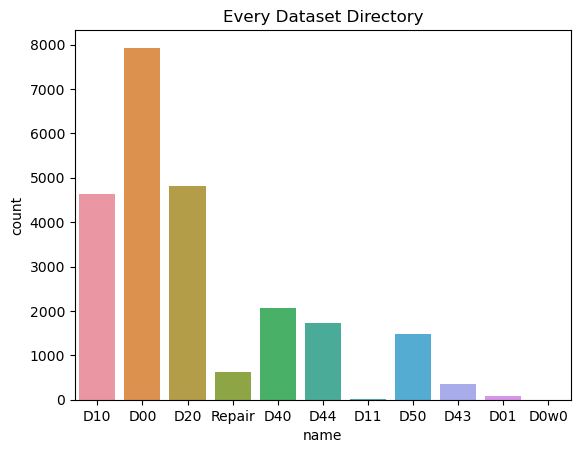

In [26]:
df_all = pd.read_csv("csvs of datastets\AllData.csv")
plt.title("Every Dataset Directory")
sns.countplot(data=df_all, x="name")

#### Percent of images without annotations, ie where no damage was picked out 

In [27]:
"{:.2f}".format(df_all["name"].isnull().sum() / len(df_all['filename'].unique()) * 100) + "%"

'33.05%'

In [28]:
"{:.2f}".format(df_all["name"].isnull().sum()/len(df_all)*100) + "%"

'33.05%'

<Axes: title={'center': 'Combined Dataset'}, xlabel='name', ylabel='count'>

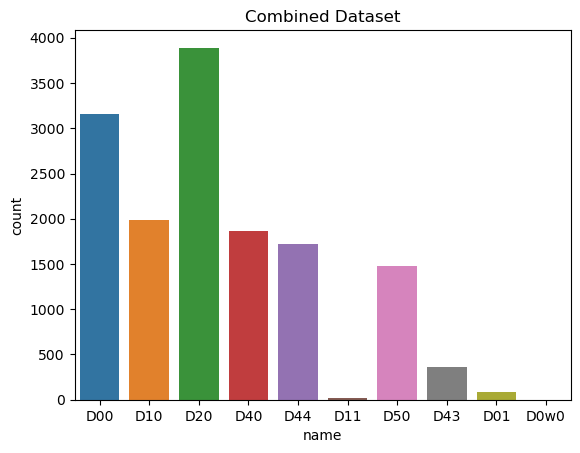

In [29]:
plt.title("Combined Dataset")
sns.countplot(data=df_cz_in_jp, x="name")

In [40]:
"{:.2f}".format(df_cz_in_jp["name"].isnull().sum() / len(df_cz_in_jp['filename'].unique()) * 100) + "%"

'30.76%'

<Axes: title={'center': 'Czech Dataset'}, xlabel='name', ylabel='count'>

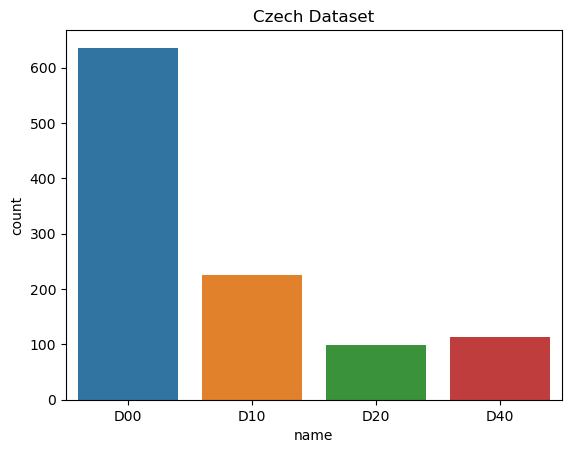

In [31]:
plt.title("Czech Dataset")
sns.countplot(data=df_cz, x="name")

In [32]:
"{:.2f}".format(df_cz["name"].isnull().sum() / len(df_cz['filename'].unique()) * 100) + "%"

'62.11%'

<Axes: title={'center': 'India Dataset'}, xlabel='name', ylabel='count'>

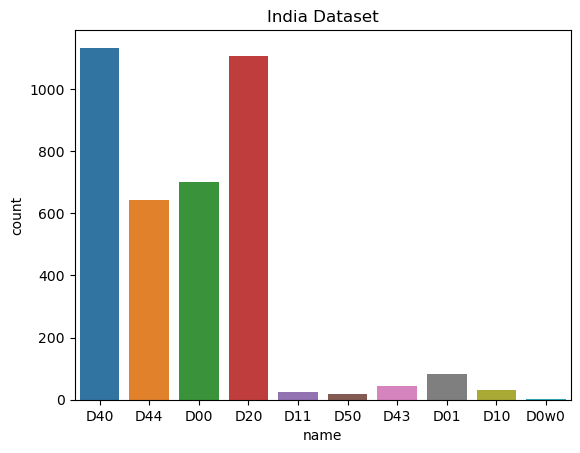

In [33]:
plt.title("India Dataset")
sns.countplot(data=df_in, x="name")

In [34]:
"{:.2f}".format(df_in["name"].isnull().sum() / len(df_in['filename'].unique()) * 100) + "%"

'50.88%'

<Axes: title={'center': 'Japan Dataset'}, xlabel='name', ylabel='count'>

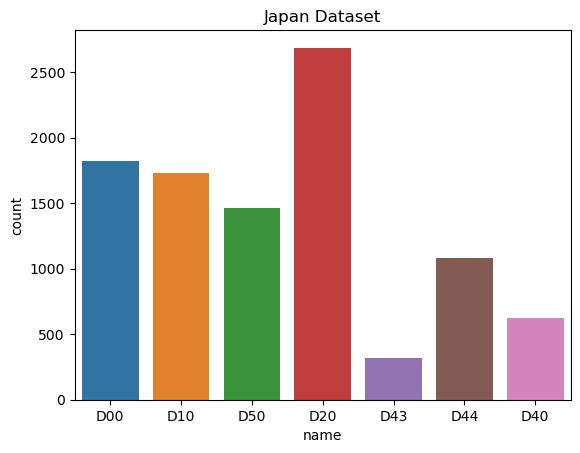

In [35]:
plt.title("Japan Dataset")
sns.countplot(data=df_jp, x="name")

In [36]:
"{:.2f}".format(df_jp["name"].isnull().sum()/len(df_all[])*100) + "%"

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2328699434.py, line 1)

<Axes: title={'center': 'USA Dataset'}, xlabel='name', ylabel='count'>

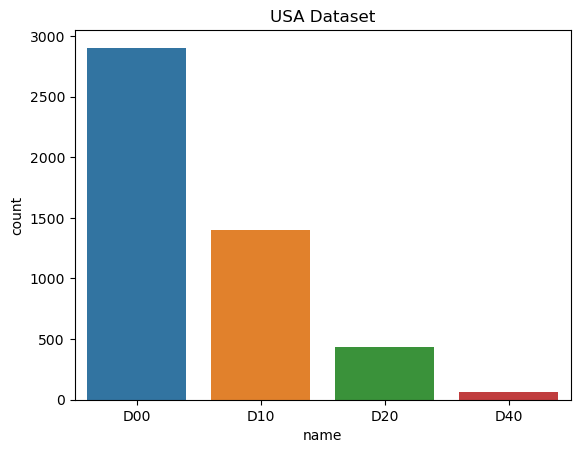

In [37]:
plt.title("USA Dataset")
sns.countplot(data=df_usa, x="name")

<Axes: title={'center': 'Norge Dataset'}, xlabel='name', ylabel='count'>

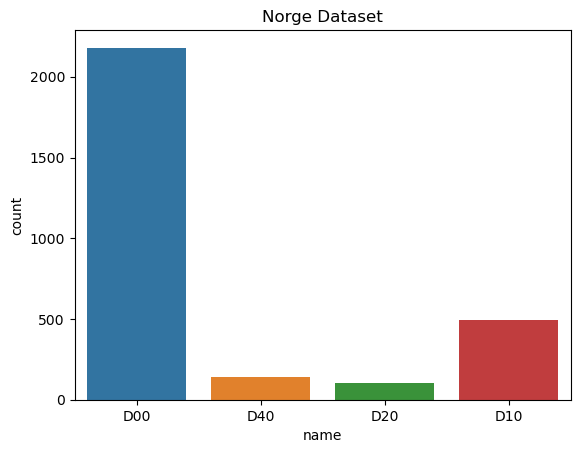

In [38]:
plt.title("Norge Dataset")
sns.countplot(data=df_norge, x="name")

### Vizualizing specific damage types

In [39]:
def find_objects_with_damage_type(name, base_dir):
    """
    Walk through a directory, open XML files, find objects with a specific name, and visualize them.
    
    Args:
        directory (str): Path to the directory containing XML files.
        name (str): Specific name to search for in object elements.
        base_dir (str): Base directory containing image and XML files.
    """
    # Walk through the directory
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.xml'):
                xml_file_path = os.path.join(root, file)
                annotations = read_annotations_from_xml(xml_file_path)
                
                # Check for objects with the specific name
                for annotation in annotations:
                    if annotation["name"] == name:
                        return  visualize_annotations(xml_file_path, base_dir)